In [1]:
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Comparison on multiple datasets

In [2]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
import os
import shap
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
import pickle
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG

from anchor import utils
from anchor import anchor_tabular
from pyuid3.data import Data
from pyuid3.entropy_evaluator import *
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches
from sklearn.preprocessing import normalize
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from pyuid3.data import Data
from pyuid3.uid3 import UId3

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [3]:
import sys
sys.path.append('./EXPLAN')
import explan
from utils import *
from LORE import lore
from LORE.neighbor_generator import *

In [4]:
def minmaxdf(df):
    maxv = df.max()
    return df/maxv

In [5]:
def anchor_fidelity_accuracy(X_train, X_test, clf, instance_to_explain ):
    explainer = anchor_tabular.AnchorTabularExplainer(
        ['0','1'],
        feature_names = X_train.columns,
        train_data = X_train.values,
        categorical_names={})
    
    exp = explainer.explain_instance(instance_to_explain, clf.predict, threshold=0.95)
    return explainer,exp

In [6]:
def decision_boundary(clf1,clf2,explain_instance, X,y,f1='x1',f2='x2'):
    explain_instance = pd.DataFrame([explain_instance], columns=X.columns)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X.loc[:, f1].min() - 0.5, X.loc[:, f1].max() + 0.5
    y_min, y_max = X.loc[:, f2].min() - 0.5, X.loc[:, f2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = np.array(clf2.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[f1,f2])))


    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig,ax= plt.subplots(1,2, figsize=(12,3))
    ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[0])

    ZZ = ZZ.reshape(xx.shape)
    ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[1])
    
    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    
    ax[0].set(title='DecTree decision boundary')
    ax[1].set(title='LUX decision boundary')
    plt.show()

In [7]:

def plot_neighbourhood(clf,X_test, y_test, X_train_sample,point, f1='x1', f2='x2', train_test_label = 'TEST'):
    explain_instance = pd.DataFrame([point], columns=X_test.columns)
    X_test_appended = pd.concat((X_test,explain_instance),axis=0,ignore_index=True)
    #y_test_appended = np.concatenate([y_test,[1]])
    y_test_appended = clf.predict(X_test_appended)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,3))

    y_test_proba = clf.predict_proba(X_train_sample)
    confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba[:,0], 'CLF_1':y_test_proba[:,1]})))


    y_test_proba_o = clf.predict_proba(X_test_appended)
    confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba_o[:,0], 
                                                                                 'CLF_1':y_test_proba_o[:,1]})))

    y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
    y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

    X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
    X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
    X_test_1_o.columns=X_test.columns

    X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
    X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
    X_test_1.columns=X_test.columns

    cmapp = cm.viridis


    c=0
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_1_o[f1], X_test_1_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_2_o[f1], X_test_2_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[0].set(title=f'Classifier uncertainty in predicions for {train_test_label}')

    #rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
    
    rect = patches.Circle(tuple(explain_instance[[f1,f2]].values.ravel()),(max(X_test[f1])-min(X_test[f1]))/4,ec='r', fc="None", ls='--', linewidth=2)

    ax[0].add_patch(rect)


    c=0

    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_1[f1], X_test_1[f2], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_2[f1], X_test_2[f2], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[1].set(title='Classifier uncertainty in predictions for neighbourhood $N$')

    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    plt.show()

In [8]:
shap.initjs()

In [9]:
def get_plot_features(lux,explain_instance,all_features = None):
    justification=lux.justify(explain_instance)[0]
    print(justification)
    features_plot = justification.split()
    f1=features_plot[1]
    f2= justification.split('AND')[-1].split()[0] if 'AND' in justification  else f1
    other_f = [f.get_name() for f in lux.uid3.tree.get_attributes() if f != "class" and f !=f1]
    if len(set([f1,f2]))<2 and len(other_f)>0:
        f2 = other_f[0]
    if len(set([f1,f2]))<2 and all_features is not None:
        f2 =[f for f in all_features if f != "class" and f !=f1][0]
    return tuple(np.sort([f1,f2]))

In [10]:
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder={}):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset


In [11]:
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
class CategoricalWrapper(BaseEstimator):
    def __init__(self, model, ohe_encoder = None, categorical_indicator=None, features = None, categories='auto'):
        if ohe_encoder is None:
            self.ohe_encoder = OneHotEncoder(categories=categories)
        else:
            self.ohe_encoder = ohe_encoder
            
        self.features = features
        self.categories=categories
        self.categorical_indicator=categorical_indicator
        self.ct = ColumnTransformer(  
            [("categorical", self.ohe_encoder, [f for f,c in zip(features,categorical_indicator) if c ] )],
        remainder='passthrough')
        
        self.model = model
    
    def fit(self, X,y):
        X_tr = self.ct.fit_transform(X)
        self.model.fit(X_tr,y)
        return self
    def predict(self,X):
        if type(X) is np.ndarray and self.features is not None:
            X = pd.DataFrame(X,columns=features)
        return self.model.predict(self.ct.transform(X))
    
    def predict_proba(self, X):
        if type(X) is np.ndarray and self.features is not None:
            X = pd.DataFrame(X,columns=features)
        return self.model.predict_proba(self.ct.transform(X))

In [12]:
def average_jackart(rule_1, rule_2, dataset, features, categorical_indicator, lux_format=False):
    total_jackart = 0
    for i,v in rule_1.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        v1 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(v))[i]
        if i in rule_2.keys():
            v2 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(rule_2[i]))[i]
            jackard = len(set(v1) & set(v2))/len((set(v1)|set(v2)))
        else:
            jackard=0
        total_jackart += jackard
    div = len(set(rule_1.keys())|set(rule_2.keys()))
    if div == 0:
        return 0
    else:
        return total_jackart/div
    

In [13]:
def coverage_precision(rule, dataset, features, categorical_indicator, prediction, 
                       class_label='class', average='micro', lux_format=False):
    query = []
    if rule == {}:
        return 0,0
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        query.append(f'{i}{op}'+f'and {i}{op}'.join(v))

    covered = dataset.query(' and '.join(query))
    predictions = np.ones(covered['class'].shape[0])*float(prediction)
    
    accuracy =  accuracy_score(covered['class'],predictions)
    precision =  precision_score(covered['class'],predictions, average=average)
    recall =  recall_score(covered['class'],predictions, average=average)
    f1 =  f1_score(covered['class'],predictions, average=average)
        
    return len(covered)/len(dataset), accuracy, precision, recall, f1

In [14]:
def stability_stats(rules_and_instances, for_explainer,dataset, features, categorical_indicator,lux_format=False):
    #TODO: calculate stats separtelly fro each class
    results_mean =[] 
    results_std =[] 
    for true_class in rules_and_instances['true_class'].unique():
        rules = rules_and_instances[rules_and_instances['true_class']==true_class]
        instance_similarity = sklearn.metrics.pairwise_distances(np.concatenate(rules['explain_instance'].values))
        jackart = np.zeros((rules.shape[0],rules.shape[0]))
        for i in range(rules.shape[0]):
            for ii in range(rules.shape[0]):
                jackart[i,ii] = average_jackart(rules.iloc[i,:][for_explainer], rules.iloc[ii,:][for_explainer], dataset, features, categorical_indicator,lux_format=lux_format)
        stab = jackart/(instance_similarity+1)
        results_mean.append(np.mean(stab))
        results_std.append(np.std(stab))
    return (np.mean(results_mean), np.mean(results_std)) #large stability, low variance is desired


In [15]:
def split_rule_conditions(rule):
    r={}
    for f,inequality in rule.items():
        partial = inequality[0].split(f)
        if len(partial)>1:
            ltparts=partial[0].split('<')
            if len(ltparts) >1:
                first = '>'+ltparts[1].strip()+ltparts[0]
            else:
                gtparts=partial[0].split('>')
                first = '<'+gtparts[1].strip()+gtparts[0]            
            second = partial[1]
            r[f] = [first,second]
        else:
            r[f] = inequality
    return r

## Main comparison loop

Accuracy  model: 0.8733689205219455 for data_house_16H
Train size: 10116
----------- Model certainty for instance: 0.8198103033666697 ---------------
Neighbourhood size: 250
Average distace of neighbourhood: 1.8381460770445741.
Train sample size: 846 (0.08362989323843416)


Permutation explainer: 848it [01:42,  7.44it/s]                                                                                                                    


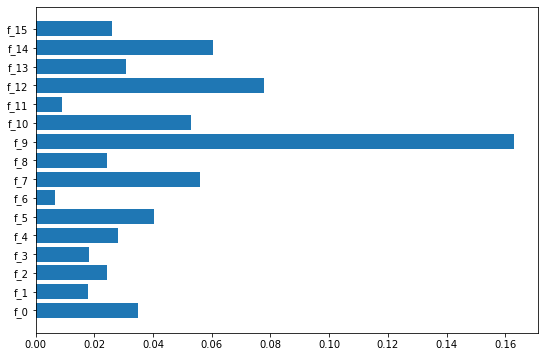

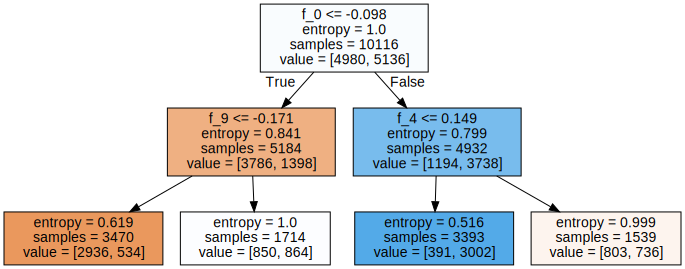

Fidelity  dectree: 0.82
Accuracy  dectree: 0.812
Lux ablation
--- 10.058116674423218 seconds ---


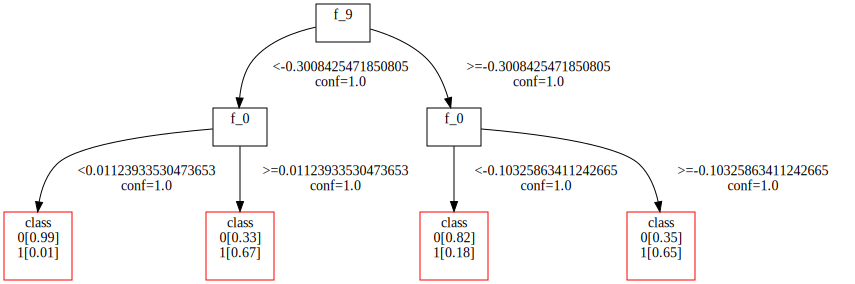

IF f_9 < -0.3008425471850805 AND f_0 < 0.01123933530473653 THEN class = 0 # 0.9889867841409693



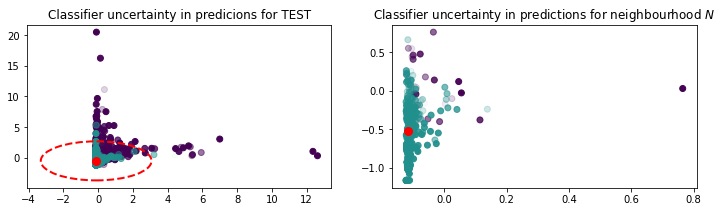

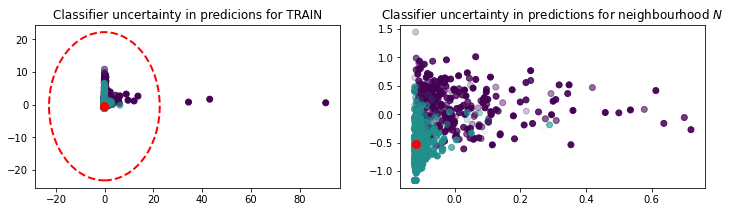

Fidelity  no proba: 0.856
Accuracy  no proba: 0.832
Lux ww proba
In fact using: 0.08362989323843416 samples from train set wiuth class balance: 0.4491725768321513
--- 14.994774580001831 seconds ---


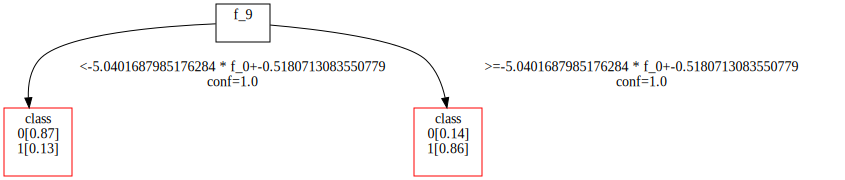

IF f_9 < -5.0401687985176284 * f_0+-0.5180713083550779 THEN class = 0 # 0.8661087866108786



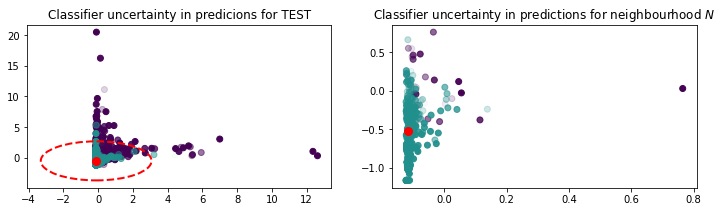

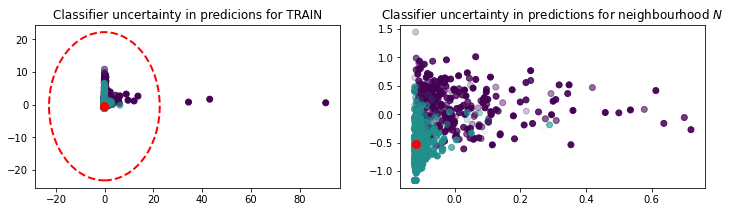

Fidelity  no proba: 0.868
Accuracy  no proba: 0.828
Lux w proba
In fact using: 0.08362989323843416 samples from train set wiuth class balance: 0.4491725768321513
--- 11.12968921661377 seconds ---


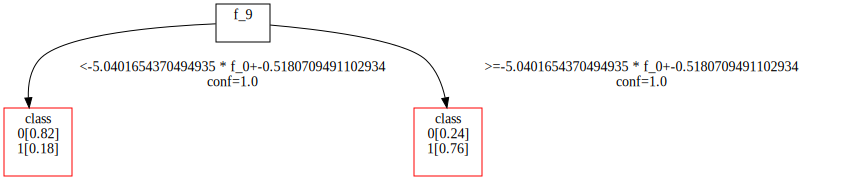

IF f_9 < -5.0401654370494935 * f_0+-0.5180709491102934 THEN class = 0 # 0.8150316012494931



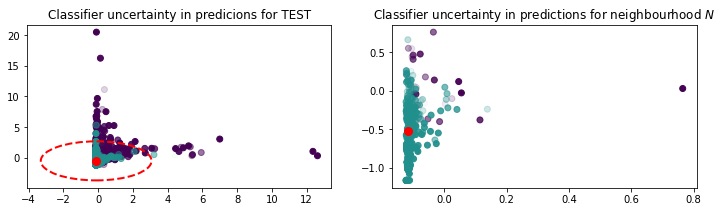

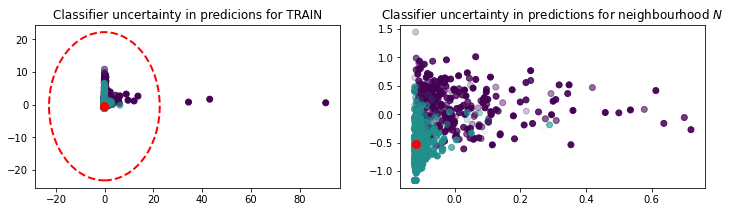

Fidelity  with proba: 0.868
Accuracy  with proba: 0.828
Lux w shap
In fact using: 0.08362989323843416 samples from train set wiuth class balance: 0.4491725768321513


Permutation explainer: 847it [01:38,  7.73it/s]                                                                                                                    


--- 126.58438372612 seconds ---


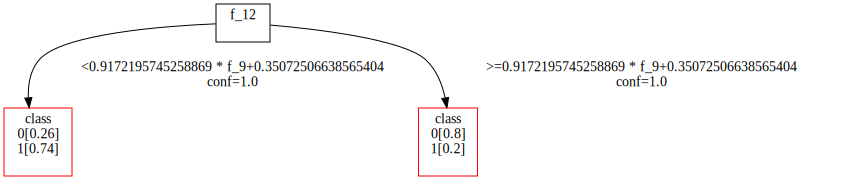

IF f_12 >= 0.9172195745258869 * f_9+0.35072506638565404 THEN class = 0 # 0.796258147365321



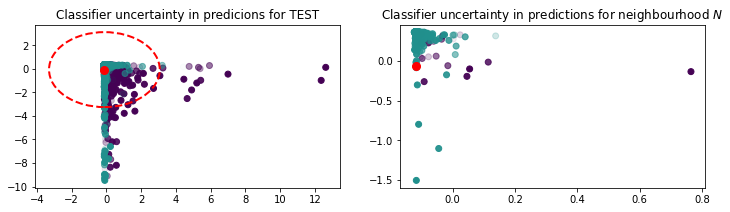

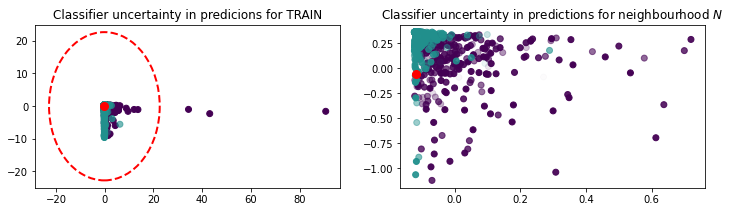

Fidelity  with shap: 0.864
Accuracy  with shap: 0.832
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 2
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 16 class: 1 weight: 0 rows: 568\n + load time: 0.012698 secs (13.71 MiB/s, 44.73 K rows/s)\n + indexing ... done\n + total time: 0.019885 secs (8.75 MiB/s, 28.56 K rows/s)\nBuilding 1 tree(s) on 568 cases\n + tree(s) built\n + size: 7 depth: 2 nf: 3 time: 0.004789 secs\nPruning tree using training set\n + tree pruned\n + size: 7 depth: 2 nf: 3 time: 7e-06 secs\n'
Fidelity  EXPLAN: 0.852
Accuracy  EXPLAN: 0.812
EXPLAN expl e = {'f_13': '>-1.183167', 'f_3': '<=1.103546'}
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 2
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 16 class: 1 weight: 0 rows: 1026\n + load time: 0.012208 secs (2

Permutation explainer: 945it [01:52,  7.69it/s]                                                                                                                    


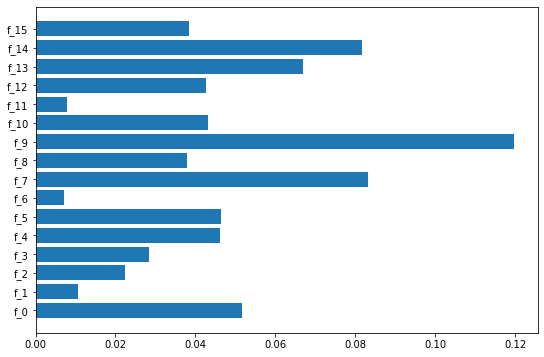

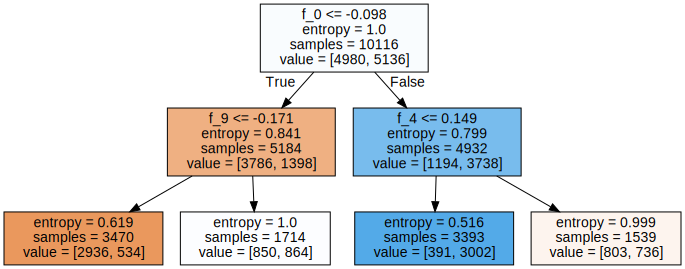

Fidelity  dectree: 0.76
Accuracy  dectree: 0.708
Lux ablation
--- 12.338244676589966 seconds ---


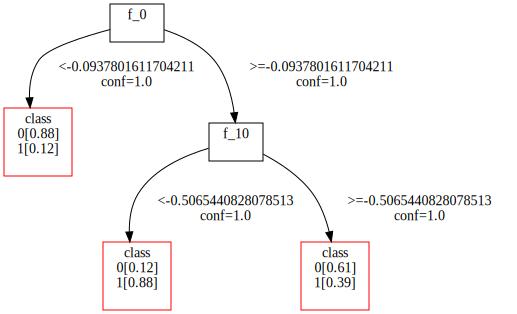

IF f_0 < -0.0937801611704211 THEN class = 0 # 0.8770833333333334



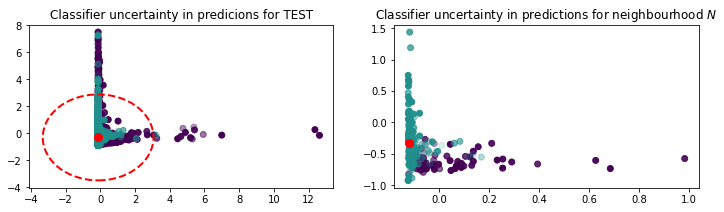

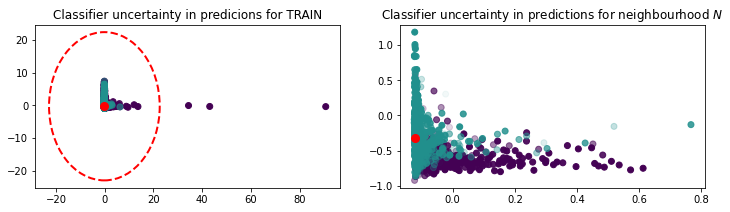

Fidelity  no proba: 0.86
Accuracy  no proba: 0.744
Lux ww proba
In fact using: 0.09321866350336101 samples from train set wiuth class balance: 0.4029692470837752
--- 18.391681671142578 seconds ---


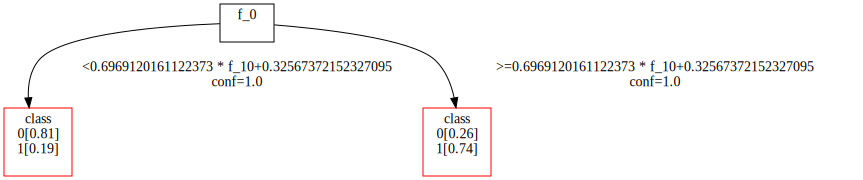

IF f_0 < 0.6969120161122373 * f_10+0.32567372152327095 THEN class = 0 # 0.8132635253054101



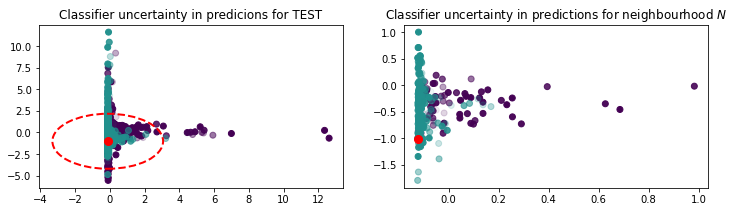

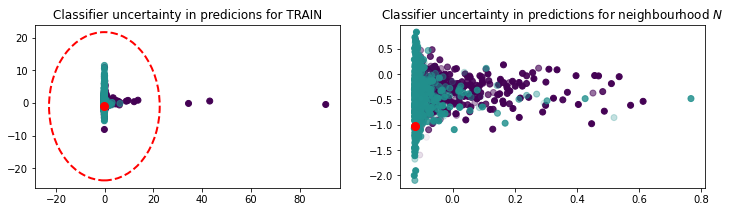

Fidelity  no proba: 0.8
Accuracy  no proba: 0.724
Lux w proba
In fact using: 0.09321866350336101 samples from train set wiuth class balance: 0.4029692470837752
--- 14.714747428894043 seconds ---


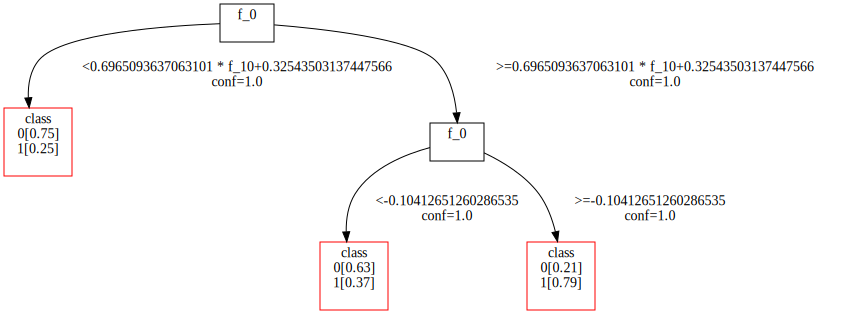

IF f_0 < 0.6965093637063101 * f_10+0.32543503137447566 THEN class = 0 # 0.7503922560433501



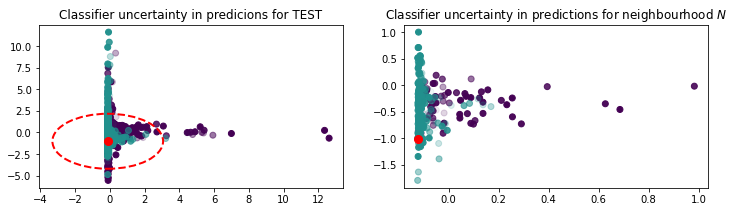

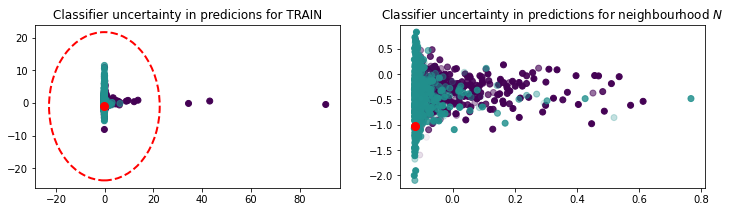

Fidelity  with proba: 0.856
Accuracy  with proba: 0.748
Lux w shap
In fact using: 0.09321866350336101 samples from train set wiuth class balance: 0.4029692470837752


Permutation explainer: 944it [01:50,  7.73it/s]                                                                                                                    


--- 142.19706964492798 seconds ---


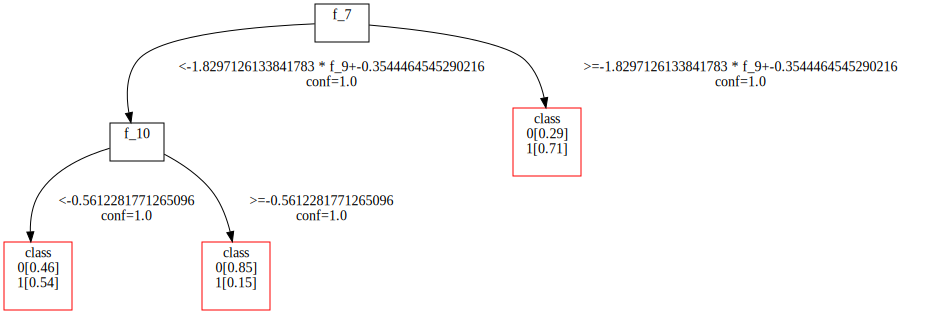

IF f_7 < -1.8297126133841783 * f_9+-0.3544464545290216 AND f_10 >= -0.5612281771265096 THEN class = 0 # 0.8484317205675216



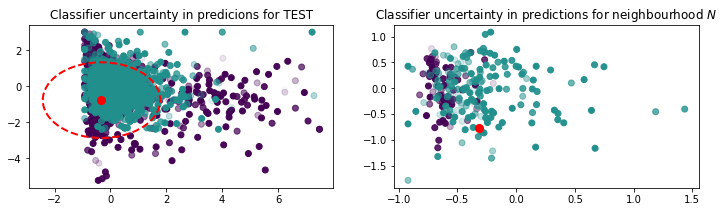

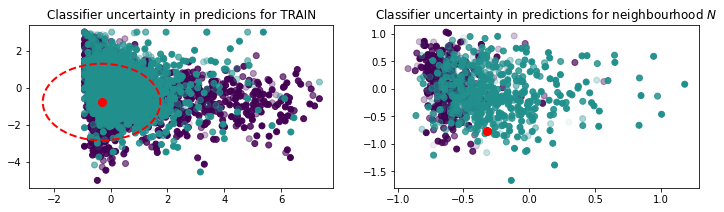

Fidelity  with shap: 0.736
Accuracy  with shap: 0.74
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 2
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 16 class: 1 weight: 0 rows: 1316\n + load time: 0.026092 secs (15.45 MiB/s, 50.43 K rows/s)\n + indexing ... done\n + total time: 0.03182 secs (12.67 MiB/s, 41.35 K rows/s)\nBuilding 1 tree(s) on 1316 cases\n + tree(s) built\n + size: 7 depth: 2 nf: 3 time: 0.007539 secs\nPruning tree using training set\n + tree pruned\n + size: 5 depth: 2 nf: 2 time: 9e-06 secs\n'
Fidelity  EXPLAN: 0.696
Accuracy  EXPLAN: 0.7
EXPLAN expl e = {'f_13': '<=0.100241', 'f_9': '<=-0.482647'}
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 2
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 16 class: 1 weight: 0 rows: 1042\n + load time: 0.01234 secs (25

Permutation explainer: 837it [01:50,  6.87it/s]                                                                                                                    


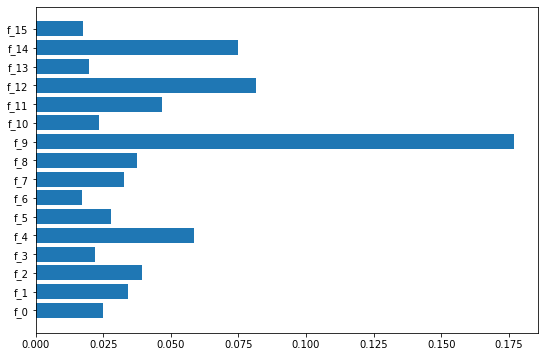

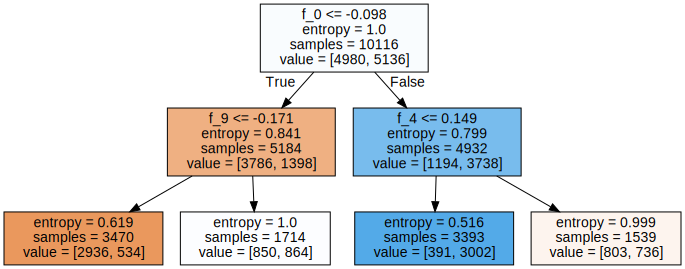

Fidelity  dectree: 0.768
Accuracy  dectree: 0.764
Lux ablation
--- 12.62247610092163 seconds ---


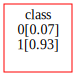

IF  THEN class = 1 # 0.932

Lux failed...
Lux ww proba
In fact using: 0.08254250691973111 samples from train set wiuth class balance: 0.5580838323353293
--- 11.586754560470581 seconds ---


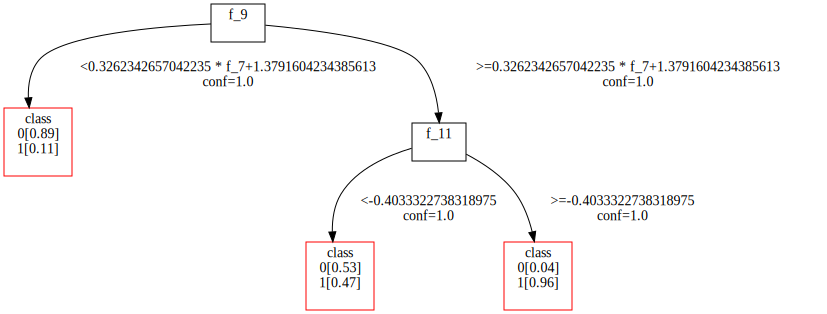

IF f_11 >= -0.4033322738318975 AND f_9 >= 0.3262342657042235 * f_7+1.3791604234385613 THEN class = 1 # 0.9559164733178654



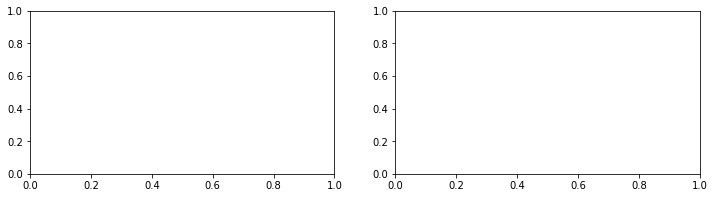

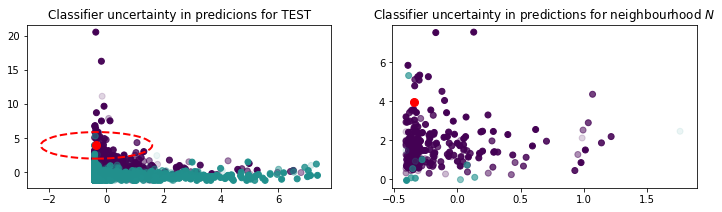

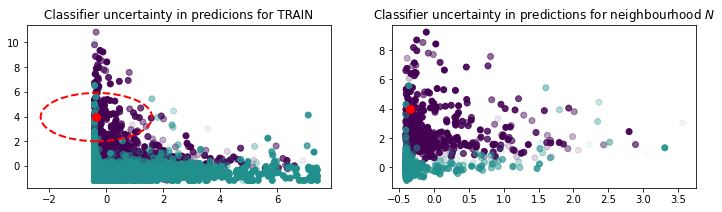

Fidelity  no proba: 0.692
Accuracy  no proba: 0.704
Lux w proba
In fact using: 0.08254250691973111 samples from train set wiuth class balance: 0.5580838323353293
--- 13.485341787338257 seconds ---


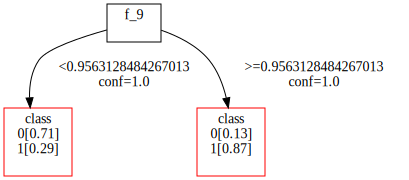

IF f_9 >= 0.9563128484267013 THEN class = 1 # 0.8705564034043964



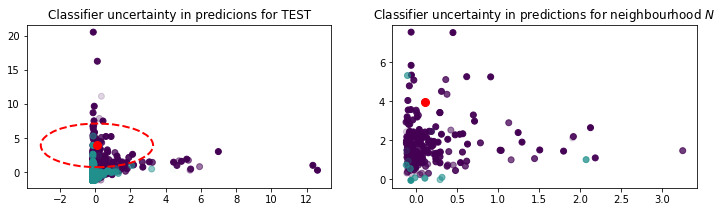

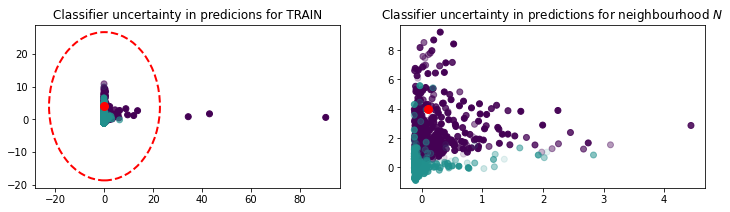

Fidelity  with proba: 0.764
Accuracy  with proba: 0.752
Lux w shap
In fact using: 0.08254250691973111 samples from train set wiuth class balance: 0.5580838323353293


In [ ]:
import time
nac_data  = []
fid_data = []
imp_fid_data=[]
features_data = []
stability_data = []
hits = []
confidences =[]
times=[]
rules = []
rule_coverages = []
rule_local_fid_data = []
explanation_length = []

rs=42
init_fraction=0.1
directory = './data/numerical_only/balanced'
#directory = './data/num_and_cat/balanced'
up=True
depth = 2
SAMPLE_SIZE=10
show=True
ismpl=True
oblique=True
synthetic = False
density_sampling=False#True
radius_sampling=False#True
oversampling=False
uncertain_entropy_evaluator=UncertainEntropyEvaluator()
representative=LUX.REPRESENTATIVE_NEAREST
categorical_indicator=None
node_size_limit = 2
n_jobs=-1

UId3.PARALLEL_ENTRY_FACTOR = 1000
nf = 4
SYNTH_BREAK=12
for num_and_cat in  os.listdir(directory):
    rules_temp = []
    clf_basic  = MLPClassifier()#GradientBoostingClassifier()#RandomForestClassifier(random_state=rs,n_jobs=-1)
    #clf = svm.SVC(probability=True,random_state=rs)
    if directory =='./data/numerical_only/balanced':
        (data, y) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
        features = [f'f_{i}' for i in range(0,data.shape[1])]
        categorical_indicator=[False]*len(features)
        clf = clf_basic
    elif directory =='./data/num_and_cat/balanced':
        (data, y, categorical_indicator) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
        features = [f'f_{i}' for i in range(0,data.shape[1])]
        density_sampling=False
        categories_data = data[:,categorical_indicator]
        categories=[np.unique(categories_data[:,i]).astype(int) for i in np.arange(categories_data.shape[1])]
        clf = CategoricalWrapper(clf_basic, None, categorical_indicator, features, categories=categories)
        
    target = 'class'
    
    if synthetic: 
        if nf > SYNTH_BREAK:
            break
        #,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.35, random_state=0)#factor=0.5
        X,y= sklearn.datasets.make_classification(n_samples=250*int(nf), n_features=nf+4, 
                                              n_informative=int(nf/2), n_redundant=int(nf/4), n_repeated=0, n_clusters_per_class=int(nf/2),
                                              n_classes=2)
        features = [f'f_{i}' for i in range(0,X.shape[1])]
        categorical_indicator=[False]*len(features)
        df = pd.DataFrame(X, columns=features)
        df[target] = y
        num_and_cat = f'n_samples={250*int(nf)};n_features={nf+4};n_informative={int(nf/2)};n_redundant={int(nf/4)};n_classes={2};n_clusters={int(nf/2)}'
        directory='synthetic'
    else:
        continuous_indicator = np.logical_not(categorical_indicator)

        df = pd.DataFrame(data,columns=features,dtype=float)
        sc = StandardScaler()
        df.loc[:,df[features].columns[continuous_indicator]]=sc.fit_transform(df[df[features].columns[continuous_indicator]])#normalize(df, axis=0)#sc.fit_transform(df)
        df[target] = y
    
    nf+=1
    #depth = len(features)+4

    if num_and_cat in ['data_Higgs','data_covertype','data_MiniBooNE']:
        continue
    if len(df) >6000:
        fraction = 1000.0/len(df)
    else:
        fraction = init_fraction
        
    
    if df[target].nunique() > 2:
        average="micro"
    else:
        average="binary"
    
    ## train xgboost, 
    train, test = train_test_split(df, random_state=rs)
    clf.fit(train[features],train[target])
    model_score = accuracy_score(clf.predict(test[features]),test[target])
    print(f'Accuracy  model: {model_score} for {num_and_cat}')
    print(f'Train size: {len(train)}')
    
    for explain_instance in test[features].sample(SAMPLE_SIZE,random_state=rs).values:
        explain_instance=np.array(explain_instance).reshape(1,-1)
        #explain_instance = test[features].sample(1).values#.astype('f8')    
        
        instance_certainty_clf = np.max(clf.predict_proba(explain_instance))
        print(f'----------- Model certainty for instance: {np.max(clf.predict_proba(explain_instance))} ---------------')
    
        # distances = sklearn.metrics.pairwise_distances(test[features], explain_instance)
        # pd.DataFrame(distances).hist()
        # plt.show()
        # _,borders = np.histogram(distances)
        # idxs,_ = np.where(distances<=borders[2])
        # dfneigh = test.iloc[idxs]
        # print(f'Neighbourhood size: {len(dfneigh)}')
        
        n_neighbors=int(len(test)*fraction) # change to 0.5? or radius?
        nn = NearestNeighbors(n_neighbors=max(1,int(n_neighbors)),n_jobs=-1)
        nn.fit(test[features])
        dst,ids_c = nn.kneighbors(np.array(explain_instance).reshape(1,-1))
        print(f'Neighbourhood size: {len(ids_c.ravel())}')
        print(f'Average distace of neighbourhood: {np.mean(dst)}.')
        dfneigh= test.iloc[ids_c.ravel()]
        
        
        start_time = time.time()
        ##############for testing dectree on the bbox sample################
        lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=fraction,max_depth=depth,  
                  node_size_limit = node_size_limit, grow_confidence_threshold = 0)
        X_train_sample, _ = lux.create_sample_bb(train[features], clf.predict(train[features]),[explain_instance], categorical=categorical_indicator,
                                                  X_importances = None, exclude_neighbourhood=False, class_names=np.unique(y),
                                                  use_parity=up, inverse_sampling=ismpl, radius_sampling=radius_sampling,oversampling=oversampling,
                                                 representative=representative,density_sampling=density_sampling,n_jobs=-1)
        print(f'Train sample size: {len(X_train_sample)} ({len(X_train_sample)/len(train)})')
        ###################################################################
        time_lux_gen = time.time() - start_time
        #shap on this sample
        #append pint as a first element and plot force plot
        X_shap = pd.concat((pd.DataFrame(explain_instance,columns=features),X_train_sample[features]))
        try:
            explainer = shap.Explainer(clf, X_shap)
            shap_values = explainer.shap_values(X_shap)
            shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][0,:],feature_names = features )
            vals= np.abs(shap_values).mean(0).mean(0)
        except TypeError:
            explainer = shap.Explainer(clf.predict_proba, X_shap)
            shap_values_obj = explainer(X_shap)
            shap_values=shap_values_obj.values
            (samples,nfeatures,nclasses) = shap_values.shape
            shap_values=np.array([abs(sv).mean(1) for sv in shap_values])
            vals= np.abs(shap_values).mean(0)
            plt.figure(figsize=(9,6))
            plt.barh(features ,vals)
            plt.show()
            
        
        #take N most relevant features and focus only on these when building explanations

        feature_importance = pd.DataFrame(list(zip(features,vals)),columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
        shapfeatures = feature_importance.head(n=10) ## see if features used in predicting the explain instance are among the top oN of shap-returned values (LOCALLY) -- do the same with global SHAP values

        data = Data.parse_dataframe(dfneigh[features+[target]],categorical=categorical_indicator)
        clf_dtree = DecisionTreeClassifier(random_state=rs,max_depth=depth,criterion='entropy')
        clf_dtree.fit(train[features],clf.predict(train[features]))

        if show:
            graph = Source(tree.export_graphviz(clf_dtree, out_file=None
               , feature_names=features, 
                                                #class_names=['0', '1'] ,
                filled = True,max_depth=depth))
            display(SVG(graph.pipe(format='svg')))

        dectree_score =  accuracy_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]))
        dectree_score_prec =  precision_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]), average=average)
        dectree_score_rec =  recall_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]), average=average)
        dectree_score_f1 =  f1_score(clf.predict(dfneigh[features]),clf_dtree.predict(dfneigh[features]), average=average)
        print(f'Fidelity  dectree: {dectree_score}')
        dectree_score_acc =  accuracy_score(clf_dtree.predict(dfneigh[features]),dfneigh[target])
        print(f'Accuracy  dectree: {dectree_score_acc}')
        
        #dtree_elen = clf_dtree.decision_path(explain_instance).shape[1]
        
        nodes = np.where(1==clf_dtree.decision_path(explain_instance).todense())[1]
        features_idxs = clf_dtree.tree_.feature[nodes][:-1]
        dtree_ats = list(set(([features[i] for i in features_idxs])))
        dtree_elen = len(dtree_ats)
        
        importance_gain_dtree = shapfeatures[shapfeatures['col_name'].isin(dtree_ats)]['feature_importance_vals'].sum()/len(dtree_ats)
        
        hit_dectree = (clf_dtree.predict(explain_instance)==clf.predict(explain_instance))
        
        ########################################################## ###### #######################################################
        ########################################################## LUX ABLATION #################################################

        print('Lux ablation')
        try:
            start_time = time.time()
            #explain xgboost without proba, 
            def noproba_predictor(x):
                preds = clf.predict_proba(x)
                hot = np.argmax(preds,axis=1)
                result = np.zeros(preds.shape)
                for i in range(0,len(result)):
                    result[i,hot[i]] = 1
                return result
            lux = LUX(predict_proba = lambda x: noproba_predictor(x), neighborhood_size=fraction,max_depth=depth,  node_size_limit =node_size_limit, grow_confidence_threshold = 0)
            #lux.attributes_names=X_train_sample.columns
            #This is commented out for the computational efficiency of the benchmark
            lux.fit(train[features], train[target], instance_to_explain=explain_instance,use_parity=False,oversampling=False,representative=representative,
                    radius_sampling=False, inverse_sampling=False ,density_sampling=False, n_jobs=-1,
                   uncertain_entropy_evaluator=uncertain_entropy_evaluator,prune=True)

            # ## To make it faster, not repeat neighbourhood selection step every time:
            # y_train_sample = lux.predict_proba(X_train_sample)
            # #limit features here
            # uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
            # udata = Data.parse_uarff_from_string(uarff)
            # print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
            # lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
            # if lux.classifier is not None:
            #     lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, depth=0,beta=1,n_jobs=n_jobs)
            # else:
            #     lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=False,beta=1,n_jobs=n_jobs)

            time_lux_ablation = time.time() - start_time+time_lux_gen
            print("--- %s seconds ---" % (time_lux_ablation))
            #calculate decision tree score over this dataset
            if show:
                lux.uid3.tree.save_dot('tree.dot')
                gvz=graphviz.Source.from_file('tree.dot')
                display(gvz)


            f1,f2=get_plot_features(lux,explain_instance,all_features = features)
            plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
            plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
            if synthetic and X_train_sample.shape[1] == 2:
                decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)

                print('Tree was cut to the ground...')

            predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
            ac_score_ablation = accuracy_score(predictions, clf.predict(dfneigh[features]))
            prec_score_ablation = precision_score(clf.predict(dfneigh[features]),predictions, average=average)
            rec_score_ablation = recall_score(clf.predict(dfneigh[features]),predictions, average=average)
            f1_score_ablation = f1_score(clf.predict(dfneigh[features]),predictions, average=average)
            print(f'Fidelity  no proba: {ac_score_ablation}')
            ac_score_ablation_acc =  accuracy_score(dfneigh[target],predictions)
            print(f'Accuracy  no proba: {ac_score_ablation_acc}')
            hit_lux_ablation = (clf.predict(explain_instance)==lux.predict(explain_instance)[0])

            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            rule_lux_ablation = justification_dict['rule']
            ablation_lux_elen = len(justification_dict['rule'].keys())

            cov_ablation, acc_ablation, prec_ablation,rec_ablation,f1_ablation = coverage_precision(rule_lux_ablation, test, features, categorical_indicator, 
                                                                                                    justification_dict['prediction'], class_label='class', average=average,
                                                                                                    lux_format=True)


            justification = lux.justify(explain_instance)[0]
            lux_conf_ablation = justification.split("#")[1]
            ats_ablation = [a.get_name() for a in lux.uid3.tree.get_attributes() if a.get_name() not in [target] and a.get_name() in justification]
            importance_gain_ablation = shapfeatures[shapfeatures['col_name'].isin(ats_ablation)]['feature_importance_vals'].sum()/len(ats_ablation)
        except:
            print('Lux failed...')
            importance_gain_ablation=0
            ats_ablation=[]
            lux_conf_ablation=0
            cov_ablation=acc_ablation=prec_ablation=rec_ablation=f1_ablation =0
            ac_score_ablation=prec_score_ablation=rec_score_ablation=f1_score_ablation=ac_score_ablation_acc=hit_lux_ablation=0
            ablation_lux_elen=0
            rule_lux_ablation={}
            
        ########################################################## ###### #######################################################
        ########################################################## LUX ######################################################

        try:
            print('Lux ww proba')
            start_time = time.time()
            #explain xgboost without proba, 
            def noproba_predictor(x):
                preds = clf.predict_proba(x)
                hot = np.argmax(preds,axis=1)
                result = np.zeros(preds.shape)
                for i in range(0,len(result)):
                    result[i,hot[i]] = 1
                return result
            lux = LUX(predict_proba = lambda x: noproba_predictor(x), neighborhood_size=fraction,max_depth=depth,  node_size_limit = node_size_limit, grow_confidence_threshold = 0)
            lux.attributes_names=X_train_sample.columns
            #This is commented out for the computational efficiency of the benchmark
            # lux.fit(train[features], train[target], instance_to_explain=explain_instance,use_parity=False,oversampling=False,representative=representative,
            #         radius_sampling=False, inverse_sampling=False ,density_sampling=False, n_jobs=-1,
            #        uncertain_entropy_evaluator=uncertain_entropy_evaluator)

            ## To make it faster, not repeat neighbourhood selection step every time:
            y_train_sample = lux.predict_proba(X_train_sample)
            #limit features here
            uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
            udata = Data.parse_uarff_from_string(uarff)
            print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
            lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
            if lux.classifier is not None:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, depth=0,beta=1,n_jobs=n_jobs,prune=True,oblique=oblique)
            else:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=False,beta=1,n_jobs=n_jobs,prune=True,oblique=oblique)

            time_lux_pure = time.time() - start_time+time_lux_gen
            print("--- %s seconds ---" % (time_lux_pure))
            #calculate decision tree score over this dataset
            if show:
                lux.uid3.tree.save_dot('tree.dot')
                gvz=graphviz.Source.from_file('tree.dot')
                display(gvz)

            f1,f2=get_plot_features(lux,explain_instance,all_features = features)
            plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
            plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
            if synthetic and X_train_sample.shape[1] == 2:
                decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)

            predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
            ac_score_pure = accuracy_score(predictions, clf.predict(dfneigh[features]))
            prec_score_pure = precision_score(clf.predict(dfneigh[features]),predictions, average=average)
            rec_score_pure = recall_score(clf.predict(dfneigh[features]),predictions, average=average)
            f1_score_pure = f1_score(clf.predict(dfneigh[features]),predictions, average=average)
            print(f'Fidelity  no proba: {ac_score_pure}')
            ac_score_pure_acc =  accuracy_score(dfneigh[target],predictions)
            print(f'Accuracy  no proba: {ac_score_pure_acc}')
            hit_lux_pure = (clf.predict(explain_instance)==lux.predict(explain_instance)[0])

            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            rule_lux_pure = justification_dict['rule']
            pure_lux_elen = len(justification_dict['rule'].keys())

            cov_pure, acc_pure, prec_pure, rec_pure, f1_pure = coverage_precision(rule_lux_pure, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')

            justification = lux.justify(explain_instance)[0]
            lux_conf_pure = justification.split("#")[1]
            ats_no_proba = [a.get_name() for a in lux.uid3.tree.get_attributes() if a.get_name() not in [target] and a.get_name() in justification]
            importance_gain_noproba = shapfeatures[shapfeatures['col_name'].isin(ats_no_proba)]['feature_importance_vals'].sum()/len(ats_no_proba)
        except:
            print('Lux failed...')
            importance_gain_noproba=0
            ats_no_proba=[]
            lux_conf_pure=0
            cov_pure= acc_pure= prec_pure= rec_pure=f1_pure  =0
            ac_score_pure=prec_score_pure=rec_score_pure=f1_score_pure=ac_score_pure_acc=hit_lux_pure=0
            pure_lux_elen=0
            rule_lux_pure={}
        ########################################################## ###### #######################################################
        ########################################################## LUX + PROBA #######################################################
        try:
            print('Lux w proba')
            start_time = time.time()
            #with proba, 
            lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=fraction,max_depth=depth,  node_size_limit = node_size_limit, grow_confidence_threshold = 0 )
            lux.attributes_names=X_train_sample.columns
            #lux.fit(train[features], train[target], instance_to_explain=explain_instance,use_parity=up, 
            #        uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,representative=representative,
            #        radius_sampling=radius_sampling,inverse_sampling= ismpl,density_sampling=density_sampling, n_jobs=-1)

            ## To make it faster, not repeat neighbourhood selection step every time:
            y_train_sample = lux.predict_proba(X_train_sample)
            #limit features here
            uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
            udata = Data.parse_uarff_from_string(uarff)
            print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
            lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
            if lux.classifier is not None:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, depth=0,beta=1,n_jobs=n_jobs,prune=True,oblique=oblique)
            else:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=False,beta=1,n_jobs=n_jobs,prune=True,oblique=oblique)

            time_lux_proba = time.time() - start_time+time_lux_gen
            print("--- %s seconds ---" % (time_lux_proba))
            if show:
                lux.uid3.tree.save_dot('tree.dot')
                gvz=graphviz.Source.from_file('tree.dot')
                display(gvz)

            f1,f2=get_plot_features(lux,explain_instance,all_features = features)
            plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
            plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
           # decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)


            predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
            ac_score_proba = accuracy_score(predictions, clf.predict(dfneigh[features]))
            print(f'Fidelity  with proba: {ac_score_proba}')
            ac_score_proba_acc =  accuracy_score(dfneigh[target],predictions)
            print(f'Accuracy  with proba: {ac_score_proba_acc}')
            prec_score_proba = precision_score(clf.predict(dfneigh[features]),predictions, average=average)
            rec_score_proba = recall_score(clf.predict(dfneigh[features]),predictions, average=average)
            f1_score_proba = f1_score(clf.predict(dfneigh[features]),predictions, average=average)
            hit_lux_proba = (clf.predict(explain_instance)==lux.predict(explain_instance)[0])

            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            rule_lux_proba = justification_dict['rule']
            proba_lux_elen = len(justification_dict['rule'].keys())

            cov_proba, acc_proba, prec_proba, rec_proba, f1_proba = coverage_precision(rule_lux_proba, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')

            justification = lux.justify(explain_instance)[0]
            lux_conf_proba = justification.split("#")[1]
            ats_with_proba = [a.get_name() for a in lux.uid3.tree.get_attributes() if a.get_name() not in [target] and a.get_name() in justification]
            importance_gain_with_proba = shapfeatures[shapfeatures['col_name'].isin(ats_with_proba)]['feature_importance_vals'].sum()/len(ats_with_proba)
        except:
            print('Lux failed...')
            importance_gain_with_proba=0
            ats_with_proba=[]
            lux_conf_proba=0
            cov_proba= acc_proba= prec_proba= rec_proba=f1_proba  =0
            ac_score_proba=prec_score_proba=rec_score_proba=f1_score_proba=ac_score_proba_acc=hit_lux_proba=0
            proba_lux_elen=0
            rule_lux_proba={}
        
        ########################################################## ###### #######################################################
        ########################################################## LUSX + SHAP #######################################################
        try:
            print('Lux w shap')
            start_time = time.time()
            lux = LUX(classifier = clf,predict_proba = clf.predict_proba, neighborhood_size=fraction,max_depth=depth,  node_size_limit = node_size_limit, grow_confidence_threshold = 0 )
            lux.attributes_names=X_train_sample.columns
            # lux.fit(train[features], train[target], 
            #         X_importances = None,uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,
            #         instance_to_explain=explain_instance,discount_importance=False,radius_sampling=radius_sampling,representative=representative,
            #         use_parity=up, inverse_sampling=ismpl,density_sampling=density_sampling, categorical=categorical_indicator,n_jobs=-1 )

            ## To make it faster, not repeat neighbourhood selection step every time:
            y_train_sample = lux.predict_proba(X_train_sample)
            #limit features here
            uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
            udata = Data.parse_uarff_from_string(uarff)
            print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
            lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
            if lux.classifier is not None:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, discount_importance=True,
                                        depth=0,beta=1,n_jobs=n_jobs,prune=True,oblique=oblique)
            else:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=True,beta=1,n_jobs=n_jobs,prune=True,oblique=oblique)


            time_lux_shap = time.time() - start_time+time_lux_gen
            print("--- %s seconds ---" % (time_lux_shap))

            if show:
                lux.uid3.tree.save_dot('tree.dot')
                gvz=graphviz.Source.from_file('tree.dot')
                display(gvz)
            f1,f2=get_plot_features(lux,explain_instance,all_features = features)
            plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
            plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
            #decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)


            predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
            ac_score_shap = accuracy_score(clf.predict(dfneigh[features]),predictions)
            print(f'Fidelity  with shap: {ac_score_shap}')
            ac_score_shap_acc = accuracy_score(dfneigh[target],predictions)
            print(f'Accuracy  with shap: {ac_score_shap_acc}')
            prec_score_shap = precision_score(clf.predict(dfneigh[features]),predictions, average=average)
            rec_score_shap = recall_score(clf.predict(dfneigh[features]),predictions, average=average)
            f1_score_shap = f1_score(clf.predict(dfneigh[features]),predictions, average=average)
            hit_lux_shap = (clf.predict(explain_instance)==lux.predict(explain_instance)[0])

            justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
            rule_lux_shap = justification_dict['rule']
            shap_lux_elen = len(justification_dict['rule'].keys())

            cov_shap, acc_shap, prec_shap, rec_shap, f1_shap = coverage_precision(rule_lux_shap, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')

            justification = lux.justify(explain_instance)[0]
            lux_conf_shap = justification.split("#")[1]
            ats_shap= [a.get_name() for a in lux.uid3.tree.get_attributes() if a.get_name() not in [target] and a.get_name() in justification]
            importance_gain_shap = shapfeatures[shapfeatures['col_name'].isin(ats_shap)]['feature_importance_vals'].sum()/len(ats_shap)
        
        except:
            print('Lux failed...')
            importance_gain_shap=0
            ats_shap=[]
            lux_conf_shap=0
            cov_shap= acc_shap= prec_shap= rec_shap= f1_shap  =0
            ac_score_shap=prec_score_shap=rec_score_shap=f1_score_shap=ac_score_shap_acc=hit_lux_shap=0
            shap_lux_elen=0
            rule_lux_shap={}
        
        ########################################################## ###### #######################################################
        ########################################################## EXPLAN #######################################################
        #X_train_sample['class'] = np.argmax(y_train_sample,axis=1)
        try:
            start_time = time.time()
            myds = prepare_ds(train,discrete=categorical_indicator)
            X, y = myds['X'], myds['y']
            instance2explain = explain_instance.ravel()

            # EXPLAN hyper-parameters
            N_samples = 3000#n_neighbors
            tau = 250#int(n_neighbors)/len(np.unique(df[target])

            # Explaining instance x using EXPLAN
            exp_EXPLAN, info_EXPLAN = explan.Explainer(instance2explain,
                                                       clf,
                                                       myds,
                                                       N_samples=N_samples,
                                                       tau=tau,depth=depth)

            time_explan = time.time() - start_time
            
            explan_y=pyyadt.predict(info_EXPLAN['C'], dfneigh[features+[target]].to_dict('records'), myds['class_name'], myds['features_type'], myds['discrete'], myds['continuous'])
            ac_score_explan = accuracy_score(clf.predict(dfneigh[features]),explan_y[0])
            print(f'Fidelity  EXPLAN: {ac_score_explan}')
            ac_score_explan_acc = accuracy_score(dfneigh[target],explan_y[0])
            print(f'Accuracy  EXPLAN: {ac_score_explan_acc}')
            print('EXPLAN expl e = %s' % exp_EXPLAN[1])
            prec_score_explan = precision_score(clf.predict(dfneigh[features]),explan_y[0], average=average)
            rec_score_explan = recall_score(clf.predict(dfneigh[features]),explan_y[0], average=average)
            f1_score_explan = f1_score(clf.predict(dfneigh[features]),explan_y[0], average=average)

            hit_explan = (clf.predict(explain_instance)==exp_EXPLAN[0][myds['class_name']])
            
            rule_EXPLAN = {} 
            for i,v in  exp_EXPLAN[1].items():
                rule_EXPLAN[i] = [v]
                
            rule_EXPLAN = split_rule_conditions(rule_EXPLAN)
            #EXPLAN expl e = {'f_2': '0.426178< f_2 <=1.226002', 'f_4': '<=0.608496', 'f_7': '>-0.403450'}
            
            cov_EXPLAN, acc_EXPLAN, prec_EXPLAN, rec_EXPLAN, f1_EXPLAN = coverage_precision(rule_EXPLAN, test, features, categorical_indicator, exp_EXPLAN[0][myds['class_name']], class_label='class')


            ats_explan = list(exp_EXPLAN[1].keys())
            explan_elen = len(ats_explan)
            importance_gain_explan = shapfeatures[shapfeatures['col_name'].isin(ats_explan)]['feature_importance_vals'].sum()/len(ats_explan)
        except:
            cov_EXPLAN=acc_EXPLAN=prec_EXPLAN=rec_EXPLAN=f1_EXPLAN=explan_elen = importance_gain_explan = prec_score_explan =rec_score_explan=f1_score_explan=ac_score_lore_explan=time_explan = np.nan
            rule_EXPLAN={}
        
        
        ########################################################## ###### #######################################################
        ########################################################## LORE #########################################################
        try:
            start_time = time.time()
            X_explain = np.concatenate(([instance2explain], myds['X']))
            exp_LORE, info_LORE = lore.explain(0, X_explain,
                                               myds, clf,
                                               ng_function=genetic_neighborhood,
                                               discrete_use_probabilities=True,
                                               continuous_function_estimation=False,
                                               returns_infos=True, path='./EXPLAN/yadt/',
                                               sep=';', log=True, depth=depth)

            time_lore = time.time() - start_time
            lore_y=pyyadt.predict(info_LORE['dt'], dfneigh[features+[target]].to_dict('records'), myds['class_name'], myds['features_type'], myds['discrete'], myds['continuous'])
            ac_score_lore = accuracy_score( clf.predict(dfneigh[features]),lore_y[0])
            print(f'Fidelity  LORE: {ac_score_lore}')
            ac_score_lore_acc = accuracy_score(dfneigh[target],lore_y[0])
            print(f'Accuracy  LORE: {ac_score_lore_acc}')
            print('LORE expl e = %s' % exp_LORE[0][1])
            prec_score_lore = precision_score(clf.predict(dfneigh[features]),lore_y[0], average=average)
            rec_score_lore = recall_score(clf.predict(dfneigh[features]),lore_y[0], average=average)
            f1_score_lore = f1_score(clf.predict(dfneigh[features]),lore_y[0], average=average)
            hit_lore = (clf.predict(explain_instance)==exp_LORE[0][0][myds['class_name']])
            
            rule_LORE = {} 
            for i,v in  exp_LORE[0][1].items():
                rule_LORE[i] = [v]
                
            rule_LORE = split_rule_conditions(rule_LORE)
            
            cov_LORE, acc_LORE, prec_LORE, rec_LORE, f1_LORE = coverage_precision(rule_LORE, test, features, categorical_indicator, exp_LORE[0][0][myds['class_name']], class_label='class')
            
            ats_lore = list(exp_LORE[0][1].keys())
            lore_elen = len(ats_lore)
            importance_gain_lore = shapfeatures[shapfeatures['col_name'].isin(ats_lore)]['feature_importance_vals'].sum()/len(ats_lore)
        except:
            cov_LORE=acc_LORE=prec_LORE=rec_LORE=f1_LORE =lore_elen = importance_gain_lore = prec_score_lore =rec_score_lore=f1_score_lore=ac_score_lore_acc=time_lore=np.nan
            rule_LORE={}
            print('LORE failed...')

        
        ########################################################## ###### #######################################################
        ########################################################## ANCHOR #######################################################
        
        try:
            start_time = time.time()
            X_explain = np.concatenate(([instance2explain], myds['X']))
            anchor_explainer = fit_anchor(myds, train[features], test[features], train[target], test[target], X_explain)
            exp_Anchor = anchor_explainer.explain_instance(X_explain[0].reshape(1, -1),
                                                                        clf.predict, threshold=np.max([0.5]+[f for f in [prec_score_lore,prec_score_explan, prec_score_shap, prec_score_proba, prec_score_pure] if f is not np.nan]))

            time_anchor= time.time() - start_time
            anch_depth = min(depth-1,len(exp_Anchor.exp_map['feature'])-1)
            ats_anchor=['f_'+str(f) for f in exp_Anchor.exp_map['feature'][:anch_depth+1]]
            importance_gain_anchor = shapfeatures[shapfeatures['col_name'].isin(ats_anchor)]['feature_importance_vals'].sum()/len(ats_anchor)


            #fit_partial = np.where(np.all(X_explain[:, exp_Anchor.features(anch_depth)] == X_explain[0][exp_Anchor.features(anch_depth)], axis=1))[0]
            #prec_anchor =  (np.mean(clf.predict(X_explain[fit_partial]) == clf.predict(X_explain[0].reshape(1, -1))))
            #cov_anchor = exp_Anchor.exp_map['coverage'][anch_depth]
            #print('Partial anchor test coverage: %.2f' % (fit_partial.shape[0] / float(X_explain.shape[0])))

            rule_Anchor_full = anchor2arule(exp_Anchor)
            rule_Anchor={}
            for i,v in rule_Anchor_full.items():
                if i in ats_anchor[:anch_depth+1]:
                    rule_Anchor[i]=[v]

            dfXExplain = build_df2explain(clf, X_explain, myds)
            cv = get_covered(rule_Anchor_full, dfXExplain.to_dict('records'), myds)
            hit_anchor = (cv[0] == 0)
            rule_Anchor = split_rule_conditions(rule_Anchor)
            print(f'Anchor explanation: {rule_Anchor}')
            anchor_elen = len(ats_anchor)
            cov_anchor, acc_anchor, prec_anchor, rec_anchor, f1_anchor = coverage_precision(rule_Anchor, test, features, categorical_indicator, exp_LORE[0][0][myds['class_name']], class_label='class')
        except:
            print('Anchor failed...')
            cov_anchor=acc_anchor=prec_anchor=rec_anchor= f1_anchor=anchor_elen = hit_anchor=importance_gain_anchor=time_anchor=np.nan
            rule_Anchor={}
    

        ########################################################## ###### #######################################################
        ########################################################## ###### #######################################################
        
        
        rules.append([num_and_cat,directory,explain_instance,rule_lux_ablation, rule_lux_pure,rule_lux_proba,rule_lux_shap,rule_EXPLAN, rule_LORE, rule_Anchor])
        rules_temp.append([explain_instance,clf.predict(explain_instance)[0],rule_lux_ablation,rule_lux_pure,rule_lux_proba,rule_lux_shap,rule_EXPLAN, rule_LORE, rule_Anchor])

        features_data.append([num_and_cat,directory,shapfeatures['col_name'].values,ats_ablation,ats_no_proba,ats_with_proba,ats_shap,ats_explan])
        
        times.append([num_and_cat,directory,time_lux_ablation,time_lux_pure, time_lux_proba, time_lux_shap, time_explan, time_lore, time_anchor])
        
        imp_fid_data.append([num_and_cat,directory,importance_gain_dtree,importance_gain_ablation,importance_gain_noproba, importance_gain_with_proba, importance_gain_shap, importance_gain_explan,importance_gain_lore,importance_gain_anchor])
        
        hits.append([num_and_cat,directory,model_score,instance_certainty_clf,hit_dectree, hit_lux_ablation,hit_lux_pure, hit_lux_proba, hit_lux_shap, hit_explan, hit_lore, hit_anchor])
        
        confidences.append([num_and_cat,directory,model_score,instance_certainty_clf,lux_conf_ablation,lux_conf_pure, lux_conf_proba, lux_conf_shap])
        
        fid_data.append([num_and_cat,directory,model_score,instance_certainty_clf,
                         dectree_score,ac_score_ablation,ac_score_pure,ac_score_proba,ac_score_shap,ac_score_explan,ac_score_lore,
                        dectree_score_prec,prec_score_ablation,prec_score_pure,prec_score_proba,prec_score_shap,prec_score_explan,prec_score_lore, 
                        dectree_score_rec,rec_score_ablation,rec_score_pure,rec_score_proba,rec_score_shap,rec_score_explan,rec_score_lore,
                        dectree_score_f1,f1_score_ablation,f1_score_pure,f1_score_proba,f1_score_shap,f1_score_explan,f1_score_lore])
        nac_data.append([num_and_cat,directory,instance_certainty_clf,ac_score_ablation_acc,ac_score_pure_acc,ac_score_proba_acc,ac_score_shap_acc, model_score, dectree_score_acc,ac_score_explan_acc,ac_score_lore_acc
                         ])
        rule_coverages.append([num_and_cat,directory,model_score,instance_certainty_clf,cov_ablation,cov_pure, cov_proba, cov_shap, cov_EXPLAN, cov_LORE, cov_anchor])
        rule_local_fid_data.append([num_and_cat,directory,model_score,instance_certainty_clf,
                              acc_ablation,acc_pure, acc_proba, acc_shap, acc_EXPLAN, acc_LORE, acc_anchor,
                              prec_ablation,prec_pure, prec_proba, prec_shap, prec_EXPLAN, prec_LORE, prec_anchor,
                              rec_ablation,rec_pure, rec_proba, rec_shap, rec_EXPLAN, rec_LORE, rec_anchor,
                              f1_ablation,f1_pure, f1_proba, f1_shap, f1_EXPLAN, f1_LORE, f1_anchor
                             ])
        explanation_length.append([num_and_cat,directory,model_score,instance_certainty_clf,dtree_elen, ablation_lux_elen,pure_lux_elen, proba_lux_elen, shap_lux_elen, explan_elen, lore_elen, anchor_elen])

    ## calculate stability here
    results_rules = pd.DataFrame(rules_temp, columns=['explain_instance','true_class','rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor'])
    stab_stats = [stability_stats(results_rules, rid, train, features, categorical_indicator) for rid in ['rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor']]
    stability_data.append([num_and_cat,directory]+list(np.concatenate(stab_stats)))
    ## save results       

## Results visualization

In [ ]:
data_prefix = './results/realx10_shallow_prune_oblique/'

In [ ]:
results_fid = pd.DataFrame(fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','dectree_score',
                                             'ac_score_ablation','ac_score_pure','ac_score_proba','ac_score_shap',  'ac_score_explan','ac_score_lore',
                                             'dectree_score_prec','prec_score_ablation','prec_score_pure','prec_score_proba','prec_score_shap','prec_score_explan','prec_score_lore',
                        'dectree_score_rec','rec_score_ablation','rec_score_pure','rec_score_proba','rec_score_shap','rec_score_explan','rec_score_lore',
                        'dectree_score_f1','f1_score_ablation','f1_score_pure','f1_score_proba','f1_score_shap','f1_score_explan','f1_score_lore']).fillna(0)
results_fid.groupby('dataset').mean().plot(style='.-',figsize=(24,9))
results_fid.to_csv(data_prefix+"synthx100_scores.csv",index=False)

In [ ]:
#all-one
plt.figure(figsize=(24,9))
sns.boxplot(data=results_fid, notch=True)
plt.xticks(rotation=90)

In [ ]:
results_fid.groupby('dataset').mean().mean().sort_values()

In [ ]:
#all-one
plt.figure(figsize=(24,9))
sns.boxplot(data=results_fid.groupby('dataset').mean(), notch=False)
plt.xticks(rotation=90)

In [ ]:
results_imp_fid = pd.DataFrame(imp_fid_data,columns=['dataset','num_and_cat','importance_gain_dtree','importance_gain_ablation','importance_gain_noproba', 'importance_gain_with_proba', 'importance_gain_shap', 'importance_gain_explan','importance_gain_lore','importance_gain_anchor']).fillna(0)
#results_imp_fid.groupby('dataset').mean().plot(style='.-',figsize=(24,9))    
results_imp_fid.to_csv(data_prefix+"synthx100_importance_gain.csv",index=False)

In [ ]:
#one-shot
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_imp_fid,notch=False,ax=ax)
plt.xticks(rotation=90)

In [ ]:
results_imp_fid.groupby('dataset').mean().mean().sort_values()

In [ ]:
results_hits = pd.DataFrame(hits,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','hits_dectree','hits_lux_ablation','hits_lux_pure', 'hits_lux_proba', 'hits_lux_shap', 'hits_explan','hits_lore','hits_anchor'], dtype='f8').fillna(0)
results_hits.to_csv(data_prefix+"synthx100_hits.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_hits.groupby('dataset').mean(),notch=True,ax=ax)
plt.xticks(rotation=90)


In [ ]:
results_times = pd.DataFrame(times,columns=['dataset','num_and_cat','time_lux_ablation','time_lux_pure', 'time_lux_proba', 'time_lux_shap', 'time_explan', 'time_lore', 'time_anchor'], dtype='f8').fillna(0)
results_times.to_csv(data_prefix+"synthx100_times.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_times.groupby('dataset').mean(),notch=False,ax=ax)
plt.xticks(rotation=90)



In [ ]:
results_conf = pd.DataFrame(confidences,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','lux_conf_ablation','lux_conf_pure', 'lux_conf_proba', 'lux_conf_shap'], dtype='f8').fillna(0)
results_conf.to_csv(data_prefix+"synthx100_confidences.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.lineplot(data=results_conf.groupby('dataset').mean().set_index('instance_certainty_clf'),ax=ax)
plt.xticks(rotation=90)



In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_conf.groupby('dataset').mean(),notch=True,ax=ax)
plt.xticks(rotation=90)


In [ ]:
results_rules = pd.DataFrame(rules, columns=['dataset','num_and_cat','explain_instance','rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor']).fillna(0)
results_rules.to_csv(data_prefix+"synthx100_rules.csv",index=False)

In [ ]:
columns_fat =[['mean_'+f, 'std_'+f] for f in ['rule_lux_ablation','rule_lux_pure','rule_lux_proba','rule_lux_shap','rule_EXPLAN', 'rule_LORE', 'rule_Anchor']] 
columns= ['dataset','num_and_cat']+[item for sublist in columns_fat for item in sublist]
results_stab_data = pd.DataFrame(stability_data, columns=columns)
results_stab_data.to_csv(data_prefix+"synthx100_stability.csv",index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_stab_data.groupby('dataset').mean(),notch=True,ax=ax)
plt.xticks(rotation=90)

In [ ]:
results_nac = pd.DataFrame(nac_data,columns=['dataset','num_and_cat','instance_certainty_clf','ac_score_ablation_acc','ac_score_pure_acc','ac_score_proba_acc','ac_score_shap_acc', 'model_score', 'dectree_score_acc','ac_score_explan_acc','ac_score_lore_acc'
                         ], dtype='f8').fillna(0)
results_nac.to_csv(data_prefix+"synthx100_nac.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_nac.groupby('dataset').mean(),notch=True,ax=ax)
plt.xticks(rotation=90)


In [ ]:
results_rulecov = pd.DataFrame(rule_coverages,columns=['dataset','num_and_cat','model_score','instance_certainty_clf','cov_ablation','cov_pure', 'cov_proba', 'cov_shap', 'cov_EXPLAN', 'cov_LORE', 'cov_anchor'
                         ], dtype='f8').fillna(0)
results_rulecov.to_csv(data_prefix+"synthx100_rulecov.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_rulecov.groupby('dataset').mean(),notch=True,ax=ax)
plt.xticks(rotation=90)

In [ ]:
results_local_fid = pd.DataFrame(rule_local_fid_data,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                              'acc_ablation','acc_pure', 'acc_proba', 'acc_shap', 'acc_EXPLAN', 'acc_LORE', 'acc_anchor',
                                                              'prec_ablation','prec_pure', 'prec_proba', 'prec_shap', 'prec_EXPLAN', 'prec_LORE', 'prec_anchor',
                                                              'rec_ablation','rec_pure', 'rec_proba', 'rec_shap', 'rec_EXPLAN', 'rec_LORE', 'rec_anchor',
                                                              'f1_ablation','f1_pure', 'f1_proba', 'f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'
                         ], dtype='f8').fillna(0)
results_local_fid.to_csv(data_prefix+"synthx100_local_fid.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_local_fid.groupby('dataset').mean(),notch=True,ax=ax)
plt.xticks(rotation=90)

In [ ]:
exp_elen = pd.DataFrame(explanation_length,columns=['dataset','num_and_cat','model_score','instance_certainty_clf',
                                                            'dtree_elen', 'ablation_lux_elen','pure_lux_elen', 'proba_lux_elen', 
                                                            'shap_lux_elen', 'explan_elen', 'lore_elen', 'anchor_elen'], dtype='f8').fillna(0)
exp_elen.to_csv(data_prefix+"synthx100_rulelen.csv",index=False)       
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=exp_elen.groupby('dataset').mean(),notch=False,ax=ax)
plt.xticks(rotation=90)

In [ ]:
print('OK')

In [ ]:
pd.DataFrame(fid_data)

In [ ]:
results_conf['dataset'].unique()

In [ ]:
X_train_sample['f_11'].unique()

In [ ]:
explain_instance

In [ ]:
jd = lux.justify(explain_instance, to_dict=True, reduce=False)#[0][0]
jd


In [ ]:
lux.uid3.tree.save_dot('tree.dot')
gvz=graphviz.Source.from_file('tree.dot')
display(gvz)

In [ ]:
f1='f_0'
f2='f_1'
plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')

In [ ]:
num_and_cat

In [ ]:
lux